# Figure 2

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import imageio
import cv2
import scipy
from itertools import product
# enables the %%R magic
import rpy2.ipython
%load_ext rpy2.ipython
import shutil

sys.path.append("./utils")
from myUtils import mkdir
from caAnalysisUtils import RunSimulation, PlotSimulation_CA, GenerateATComparisonPlot_CA, GenerateATComparisonPlot_ODE, PlotCompetitionOverTime

# Format plots
sns.set(style="white",
        font_scale=2.,
        font="Serif",
        rc={'figure.figsize':(12,6)})

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [65]:
### Script parameters
colorDic = {'MTD':'#FF9409','AT50':'#094486'}
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script

# Load large scale parameter sweep data (n=1000). Generated using the 'collectData_n0-fRSweep.py' script
txComparisonDf = pd.read_csv("./data/n0Sweep.csv",index_col=0)
txComparisonDf = txComparisonDf[txComparisonDf.Cost==0].copy()

## a) Example simulation for n0 = 0.75 and fR = 0.001

In [66]:
# Params for the figure
initialSize = 0.75
rFrac = 0.001
nReplicates = 250
tEnd = 365*10
seedToShowImagesFor = 0
dataDir = "./data/exampleSims_noCost_noTurnover/data/"
imgDir = "./data/exampleSims_noCost_noTurnover/images/"

### Collect Data

In [9]:
# Collect the data for the time series plots showing the treatment dynamics avaraged across nReplicate simulations
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":0,"cost":0,
                      "tEnd":tEnd,"nReplicates":nReplicates,
                      "profilingMode":"false","terminateAtProgression":"false",
                      "outDir":dataDir}
    RunSimulation(modelConfigDic)

In [11]:
# Collect the images for one replicate
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":0,"cost":0,
                      "tEnd":tEnd,"seed":seedToShowImagesFor,"nReplicates":1,
                      "profilingMode":"false","terminateAtProgression":"true",
                      "imageOutDir":imgDir,"imageFreq":10,
                      "outDir":"./data/scratch/"}
    RunSimulation(modelConfigDic)

### Plot the simulations

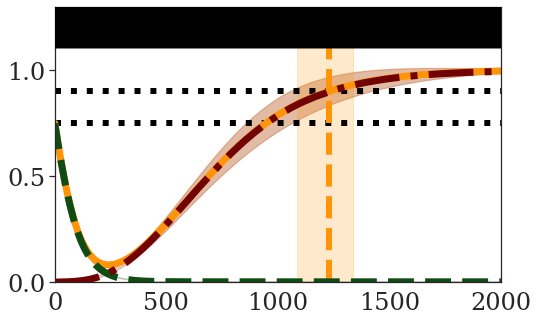

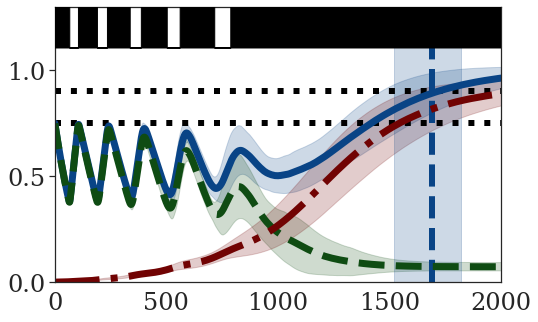

In [24]:
for i,txName in enumerate(["MTD","AT50"]):
    tmpList = []
    for replicateId in range(nReplicates):
        currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
        tmpDf = pd.read_csv(currDfName)
        tmpDf['NCells'] /= 1e4
        tmpDf['NCells_S'] /= 1e4
        tmpDf['NCells_R'] /= 1e4
        tmpDf['TreatmentBranch'] = txName
        tmpDf['ReplicateId'] = replicateId
        tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
#     dataDf.to_csv("./data/data_exampleSim_fig2_%s.csv"%txName)
    # Plot
    PlotSimulation_CA(dataDf,xlim=2e3,yLimVec=[0,1.3],
                      colorA=[colorDic[txName]],showProgression=True,
                      figsize=(8,5),savefigB=True,outName="figures/exampleSim_noCost_noTurnover_%s.pdf"%txName)

### Compute difference in TTP

In [114]:
tmpList = []
for i,txName in enumerate(["MTD","AT50"]):
    for replicateId in range(nReplicates):
        currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
        tmpDf = pd.read_csv(currDfName)
        ttp = tmpDf.Time[(tmpDf.NCells>1.2*tmpDf.NCells.iloc[0]) & 
                 (tmpDf.Time > 150)].min() 
        # The 150 prevents spurious calls of progression which 
        # can sometimes occur early in AT due to very rapid regrowth, 
        # even thought the tumour remains controllable.
        tmpList.append({"TreatmentBranch":txName,"ReplicateId":replicateId,"TTP":ttp})
ttpDataDf = pd.DataFrame(tmpList)

In [115]:
from scipy.stats import sem, t
confidence = 0.95

sample_MTD = ttpDataDf.TTP[ttpDataDf.TreatmentBranch=="MTD"].values/30
sample_AT50 = ttpDataDf.TTP[ttpDataDf.TreatmentBranch=="AT50"].values/30
# scipy.stats.ttest_rel(sample_MTD,sample_AT50,
#                       nan_policy='omit')

m = np.nanmean(sample_AT50-sample_MTD)
std_err = sem(sample_AT50-sample_MTD)
h = std_err * t.ppf((1 + confidence) / 2, nReplicates - 1)
print("Mean difference: %1.2f; [%1.2f,%1.2f]"%(m,m-h,m+h))

Mean difference: 15.34; [14.81,15.86]


## b) Example Images for seed 0

### Check that this seed is representative of the dynamics

MTD Mean TTP: 1245.00
AT50 Mean TTP: 1559.00


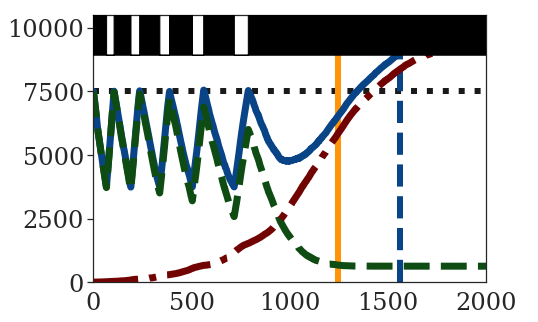

In [11]:
tmpList = []
for i,txName in enumerate(["MTD","AT50"]):
    currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,seedToShowImagesFor))
    tmpDf = pd.read_csv(currDfName)
    tmpDf['TreatmentBranch'] = txName
    tmpDf['ReplicateId'] = replicateId
    tmpList.append(tmpDf)
dataDf = pd.concat(tmpList)
dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
# Plot
GenerateATComparisonPlot_CA(dataDf,t_end=2e3,printTTPB=True,figsize=(8,5))

### Plot the images

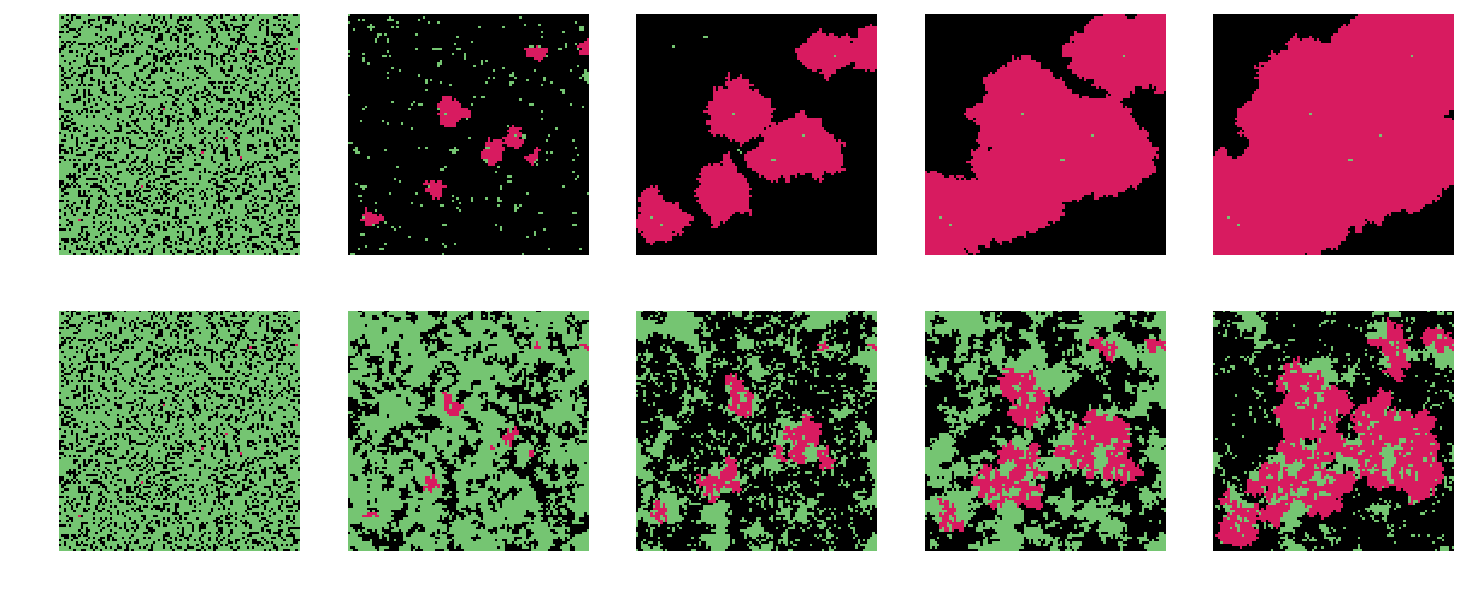

In [12]:
timePointList = [0,250,500,750,1000]

fig,axList = plt.subplots(2,len(timePointList),figsize=(len(timePointList)*5,10))
for i,timePoint in enumerate(timePointList):
    for j,txName in enumerate(["MTD","AT50"]):
        # Load image
        currImgDir = os.path.join(imgDir,"%s_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,rFrac,initialSize,seedToShowImagesFor))
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

        currAx = axList[j,i]
        currAx.imshow(currImg)
        currAx.axis('off')
plt.savefig("figures/exampleSim_noCost_noTurnover_images.pdf")

### GIFs

In [13]:
for j,txName in enumerate(["MTD","AT50"]):
    # Make an inventory of the images that are available
    currImgDir = os.path.join(imgDir,"%s_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,rFrac,initialSize,seedToShowImagesFor))
    fNameList = [int(float(x.split("_")[-1].split(".png")[0])) for x in os.listdir(currImgDir) if x.split(".")[-1]=="png"]
    fNameList.sort()
    images = []
    for tId in fNameList[::2]:
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(tId))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
        currImg = cv2.putText(currImg, 't = %dd'%tId, (10,190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Add a square to indicate that drug is on
        currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,seedToShowImagesFor))
        tmpDf = pd.read_csv(currDfName)
        if tmpDf[tmpDf.Time==tId].DrugConcentration.iloc[0]>0:
            cv2.rectangle(currImg, (175, 25), (197, 3), (255,255,255), -1)
        images.append(currImg)
    imageio.mimsave(os.path.join("gifs","exampleSim_%s.gif"%txName), images, duration=.1)

## c ) Quantifying competition by measuring blocking of resistant cell divisions

In [67]:
# Params for the figure
tumourList = [(0.75,0.001),(0.25,0.001),(0.75,0.01)]
nReplicates = 250
tEnd = 2.1e3
dataDir = "./data/exampleSims_noCost_noTurnover/data/"

### Collect Data

In [14]:
# Collect the data with the reduced density and increased resistance fraction for analysis of the effect on competition
if runCASimulations:
    for initialSize, rFrac in tumourList[1:]:
        modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":0,"cost":0,
                          "tEnd":tEnd,"nReplicates":nReplicates,
                          "profilingMode":"false","terminateAtProgression":"false",
                          "outDir":dataDir}
        RunSimulation(modelConfigDic)

### Plot

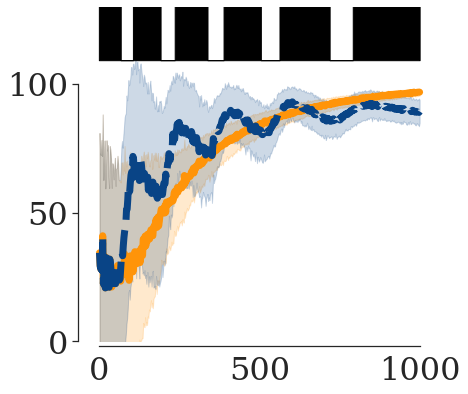

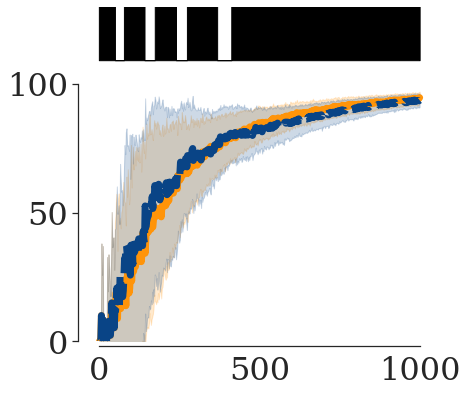

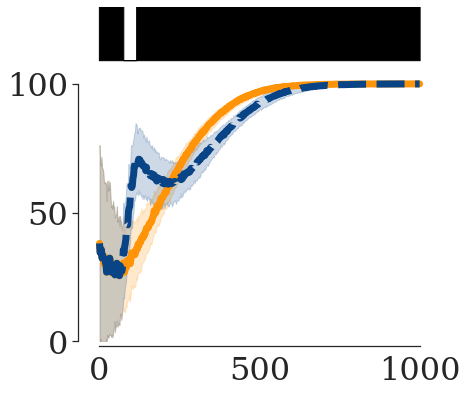

In [27]:
for figId, (initialSize, rFrac) in enumerate(tumourList):
    fig,ax = plt.subplots(1,1,figsize=(7,6))
#     # Determine which replicates to plot (plot those for the most common cycle number)
#     mostCommonCycleNum = txComparisonDf.MaxNCycles[(txComparisonDf.RFrac==rFrac) &
#                                      (txComparisonDf.InitialTumourSize==initialSize)].mode()[0]
#     replicateIdList = txComparisonDf.ReplicateId[(txComparisonDf.RFrac==rFrac) &
#                                      (txComparisonDf.InitialTumourSize==initialSize) &
#                                      (txComparisonDf.MaxNCycles==mostCommonCycleNum)]
#     replicateIdList = np.arange(nReplicates)#replicateIdList[replicateIdList<250].values
#     print("n0: %1.3f, NCycles: %d, NSamples: %d"%(initialSize,mostCommonCycleNum,len(replicateIdList)))
    tmpList = []
    for i,txName in enumerate(["MTD","AT50"]):
        for replicateId in range(nReplicates):
            currDfName = os.path.join(dataDir,"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            tmpDf['TreatmentBranch'] = txName
            tmpDf['ReplicateId'] = replicateId
            tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    dataDf = dataDf[dataDf.Time<1000]
    dataDf = dataDf[::2]
    dataDf['PropFailedDivs'] = dataDf.NFailedDivs/dataDf.NAttemptedDivs*100
#     dataDf.to_csv("./data/fig2c_%d.csv"%figId)
    PlotCompetitionOverTime(dataDf,decoratey=i>0,ylim=130,y2lim=1/1.2,errStyle='sd',ax=ax)
    plt.tight_layout()
    plt.savefig("figures/competitionPlots_n0_%1.1f_fR_%1.3f.pdf"%(initialSize,rFrac))

## d) Neighbourhood Analysis

### Code

#### Code for neighbourhood analysis

In [68]:
def RunNeighbourhoodAnalysis(nReplicates,modelConfigDic):
    tmpDicList = []
    for replicateId in tqdm(range(nReplicates),total=nReplicates):
        # Simulate treatment
        modelConfigDic['seed'] = replicateId
        RunSimulation(modelConfigDic)

        # Analyse neighbourhood structure
        for txName in ["MTD","AT50"]:
            # Read info for this run
            currDfName = os.path.join(modelConfigDic['outDir'],"%s_cellCounts_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,rFrac,initialSize,replicateId))
            tmpDf = pd.read_csv(currDfName)
            for timePoint in np.arange(0,tmpDf.Time.max(),imageFreq):
                # Plot the image
                currImgDir = os.path.join(modelConfigDic['outDir'],"%s_cost_0.0_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,rFrac,initialSize,replicateId))
                currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
                currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)

                # Count the number of neighbours for each resistant cell
                sensitiveMask = (currImg[:,:,0] == 117)*1        
                resistantMask = (currImg[:,:,0] == 216)*1
                k = np.array([[0,1,0],[1,0,1],[0,1,0]])
                nNeighbourhoodSites = np.sum(k)
                nResistantNeighboursMat = scipy.ndimage.convolve(resistantMask, k, mode='constant', cval=0.0)
                nResistantNeighboursMat[resistantMask==0] = 0

                nSensitiveNeighboursMat = scipy.ndimage.convolve(sensitiveMask, k, mode='constant', cval=0.0)
                nSensitiveNeighboursMat[resistantMask==0] = 0

                nEmptySpaceNeighboursMat = np.ones_like(nSensitiveNeighboursMat)*nNeighbourhoodSites - nSensitiveNeighboursMat - nResistantNeighboursMat
                nEmptySpaceNeighboursMat[resistantMask==0] = 0

                # Save results
                nCells_R = np.sum(resistantMask)
                tmpDicList.append({"Treatment":txName,"ReplicateId":replicateId,"Time":timePoint,
                                   "DrugConcentration":tmpDf.DrugConcentration[tmpDf.Time==timePoint].values[0],
                                   "FracSensitive":np.sum(nSensitiveNeighboursMat)/nCells_R/nNeighbourhoodSites,
                                   "FracResistant":np.sum(nResistantNeighboursMat)/nCells_R/nNeighbourhoodSites,
                                   "FracEmpty":np.sum(nEmptySpaceNeighboursMat)/nCells_R/nNeighbourhoodSites})
    shutil.rmtree(modelConfigDic['outDir'])
    return pd.DataFrame(tmpDicList)

In [69]:
def Convert2EvoFreq(dataDf,colList=['FracSensitive','FracResistant','FracEmpty']):
    currDataDf = dataDf.groupby('Time').mean()[colList]
    currDataDf = currDataDf.transpose()
    currDataDf.reset_index(inplace=True); currDataDf.rename(columns={'index':'Neighbour'},inplace=True)
    currDataDf.insert(1, 'CloneID', currDataDf.index+1); currDataDf.insert(2, 'ParentID', 0)
    # Add a dummy 'parent' to use for visulasation within EvoFreq
    currDataDf.loc[-1,:] = 0
    currDataDf.loc[-1,'Neighbour'] = 'Dummy'
    currDataDf['Color'] = ['#75C571','#D5115A','#000000','#000000']
    return currDataDf

#### Import EvoFreq

In [70]:
%%R
library(EvoFreq)


Error in library(EvoFreq) : there is no package called ‘EvoFreq’


/Users/4473010/opt/miniconda3/envs/py3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in library(EvoFreq) : there is no package called ‘EvoFreq’

  warnings.warn(x, RRuntimeWarning)


### Analyse neighbourhood for simulation in a)

In [24]:
# Params for the figure
initialSize = 0.75
rFrac = 0.001
cost = 0
turnover = 0
nReplicates = 250
tEnd = 1000
imageFreq = 10
outDir = "data/neighbourhoodAnalysis/"
modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":turnover,"cost":cost,
                  "tEnd":tEnd,"nReplicates":1,
                  "profilingMode":"false","terminateAtProgression":"false",
                  "imageOutDir":"./tmp/neighbourhoodAnalysis/","imageFreq":imageFreq,
                  "outDir":"./tmp/neighbourhoodAnalysis/"}

In [25]:
neighbourhoodStructureDf = RunNeighbourhoodAnalysis(nReplicates,modelConfigDic)
mkdir(outDir)
for txName in ["MTD","AT50"]:
    tmpDf = Convert2EvoFreq(neighbourhoodStructureDf[neighbourhoodStructureDf.Treatment==txName])
    tmpDf.to_csv(os.path.join(outDir,"neighbourhoodAnalysis_%s.csv"%txName),index=False)
neighbourhoodStructureDf.to_csv(os.path.join(outDir,"neighbourhoodAnalysisDf.csv"))

100%|██████████| 250/250 [22:47<00:00,  5.47s/it]


In [29]:
%%R -i outDir
evofreq_args = list("interpolation_steps"=0,"threshold"=0.0)
for (txName in c("MTD","AT50")) {
    hal_info = read.HAL(print(paste(c(outDir,"neighbourhoodAnalysis_",txName,".csv"),collapse="")), 
                        fill_name = "Color", 
                        get_evofreq_arg_list = evofreq_args)
    fp = plot_evofreq(hal_info$freq_frame, bw=1.0, show_axes=FALSE)
    ggsave(paste(c("./figures/neighbourhoodAnalysis_",txName,".pdf"),collapse=""),width=15,height=5)
}

[1] "data/neighbourhoodAnalysis/neighbourhoodAnalysis_MTD.csv"

[1] "Getting Mutation Counts"
  |======================================================================| 100%
[1] "Getting Plot Positions"
[1] "data/neighbourhoodAnalysis/neighbourhoodAnalysis_AT50.csv"

[1] "Getting Mutation Counts"
  |======================================================================| 100%
[1] "Getting Plot Positions"


## e) (N0,fR) Parameter Sweep - Time to Progression

In [28]:
# Load the data
txComparisonDf_noTurnover = txComparisonDf[txComparisonDf.Turnover==0].copy()
txComparisonDf_noTurnover['InitialTumourSize'] *= 100
txComparisonDf_noTurnover.InitialTumourSize = txComparisonDf_noTurnover.InitialTumourSize.astype(int)
# txComparisonDf_noTurnover.to_csv("./data/fig2_e.csv")

# Compute the mean value to be used in the plot
summaryStatsDf = txComparisonDf_noTurnover.groupby(["InitialTumourSize","RFrac"]).mean()
summaryStatsDf = summaryStatsDf.reset_index(level=['InitialTumourSize', 'RFrac'])
summaryStatsDf.rename(columns={"RelTimeGained_CA":"MeanRelTimeGained_CA"},inplace=True)

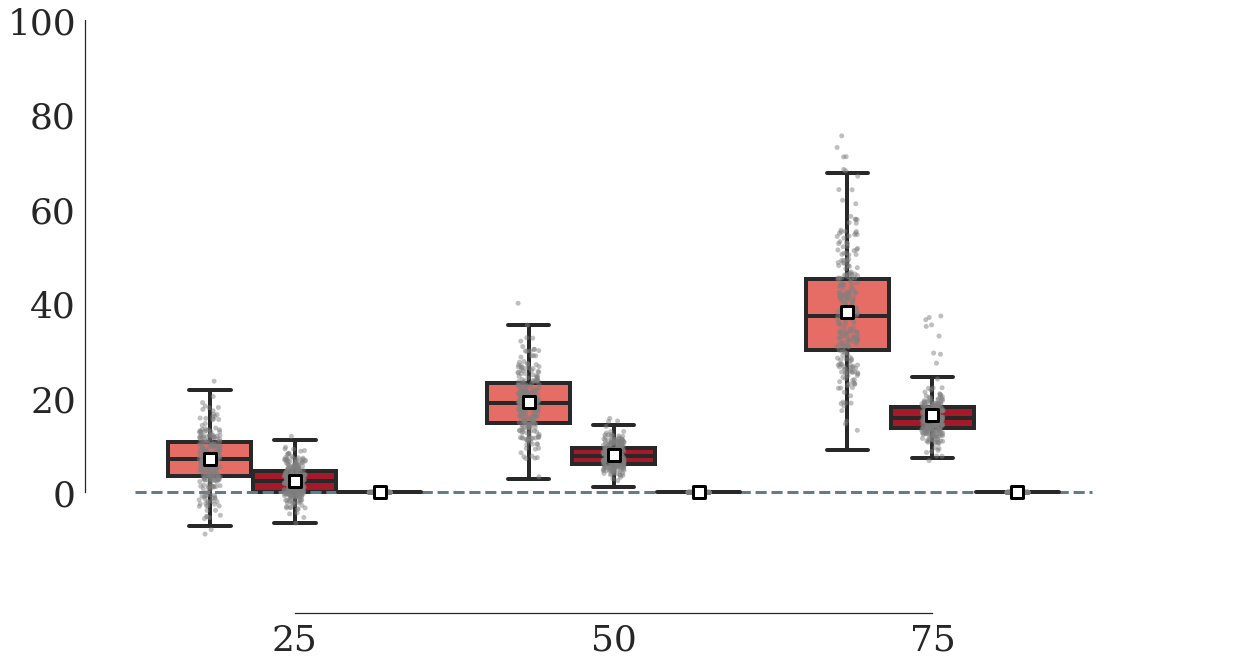

In [9]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

txComparisonDf_noTurnover['InitialTumourSize'] = txComparisonDf_noTurnover.InitialTumourSize.astype('category')


sns.stripplot(x="InitialTumourSize",y="RelTimeGained_CA",alpha=0.5,dodge=True,
             hue="RFrac", palette=["grey","grey","grey"],
             ax=ax,data=txComparisonDf_noTurnover[::4])
sns.swarmplot(x="InitialTumourSize",y="MeanRelTimeGained_CA",dodge=True,
              hue="RFrac",palette=["white","white","white"],
              s=12,marker="s",linewidth=3,edgecolor="black",              
              ax=ax,data=summaryStatsDf)
sns.boxplot(x="InitialTumourSize",y="RelTimeGained_CA", showfliers=False,
            palette=sns.xkcd_palette(['coral','scarlet','dark red']),
            linewidth=4,dodge=True,#width=0.6,
             hue="RFrac",
             ax=ax,data=txComparisonDf_noTurnover)

ax.plot(np.linspace(-0.5,len(txComparisonDf_noTurnover.InitialTumourSize.unique())-0.5,100),
        np.repeat(0,100),color=sns.xkcd_rgb['blue grey'],lw=3,ls='--')
ax.set_xlim(-0.5,len(txComparisonDf_noTurnover.InitialTumourSize.unique()))
ax.set_ylim(-15,100)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=36)
ax.get_legend().remove()
sns.despine(offset=50, trim=True)
# plt.xticks(rotation=45);
plt.savefig("figures/ttpBoxPlots_noCost_noTurnover.pdf")

In [12]:
print(txComparisonDf_noTurnover.RelTimeGained_CA.max())
print(txComparisonDf_noTurnover.RelTimeGained_CA.min())
print(1-np.sum(txComparisonDf_noTurnover.RelTimeGained_CA<0)/txComparisonDf_noTurnover.shape[0])

89.58509737510582
-9.102402022756005
0.964
